In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Using ResNet for CNN visualization

In [2]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from torchvision import datasets, models, transforms
from torchvision.models import resnet50, ResNet50_Weights

import numpy as np
import matplotlib.pyplot as plt

In [3]:
import os
import zipfile

if not os.path.exists("/content/drive/MyDrive/Visualization/Data/hymenoptera_data"):
  with zipfile.ZipFile("/content/drive/MyDrive/Visualization/Data/hymenoptera_data.zip","r") as zip_ref:
      zip_ref.extractall("/content/drive/MyDrive/Visualization/Data/")

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/Visualization/Data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

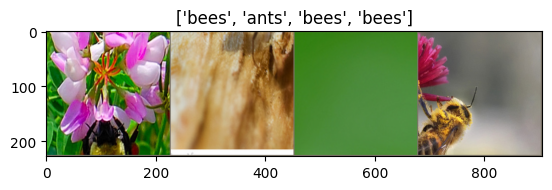

In [5]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
#Untrained ResNet50
model = resnet50()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model.to(device)

#PreTrained ResNet50
pretrained_model = resnet50(weights=ResNet50_Weights.DEFAULT)
num_ftrs = pretrained_model.fc.in_features
pretrained_model.fc = nn.Linear(num_ftrs, 2)
pretrained_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(pretrained_model.parameters(), lr=0.001, momentum=0.9)

In [8]:
def filter_visualization(filter):
  inp = filter.cpu().numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  return inp

In [9]:
def layer_listing(model):
  # we will save the conv layer weights in this list
  model_weights =[]
  #we will save the 49 conv layers in this list
  conv_layers = []
  # get all the model children as list
  model_children = list(model.children())
  #counter to keep count of the conv layers
  counter = 0
  #append all the conv layers and their respective wights to the list
  for i in range(len(model_children)):
      if type(model_children[i]) == nn.Conv2d:
          counter+=1
          model_weights.append(model_children[i].weight)
          conv_layers.append(model_children[i])
      elif type(model_children[i]) == nn.Sequential:
          for j in range(len(model_children[i])):
              for child in model_children[i][j].children():
                  if type(child) == nn.Conv2d:
                      counter+=1
                      model_weights.append(child.weight)
                      conv_layers.append(child)
  return conv_layers, model_weights

In [10]:
def visualize(conv_layers, model_weights, input):
  cols = 7  # Number of columns in the grid
  rows = len(conv_layers) // cols

  fig, axes = plt.subplots(rows, cols, figsize=(64, 64))

  i = 0
  for layer in conv_layers:
    out = layer(input)
    input = out
    out = torch.sum(out,axis = 0)
    subset_channels = out
    subset_channels = subset_channels.cpu()
    # Convert the output to NumPy array and reshape if needed
    output_np = subset_channels.detach()
    ax = axes[i // cols, i % cols]
    ax.imshow(output_np)
    ax.axis('off')
    ax.set_title(f'Conv2d({layer.in_channels}, {layer.out_channels}, \n kernel_size={layer.kernel_size})', fontsize = 30)
    i+=1
  plt.show()

  filters = model_weights[0]
  num_filters = filters.size(0)
  cols = 8  # Number of columns in the grid
  rows = num_filters // cols

  fig, axes = plt.subplots(rows, cols, figsize=(7, 7))
  for i in range(num_filters):
      ax = axes[i // cols, i % cols]
      ax.imshow(filter_visualization(filters[i].detach()))
      ax.axis('off')
  plt.show()

### Untrained ResNet50
We can first take a look at the untrained ResNet50, being trained on the small subsample of ImageNet, specifically the ants and bees subset. As we will see, even after 2000 epochs, the filters do not change much, and the loss is quite noisy.

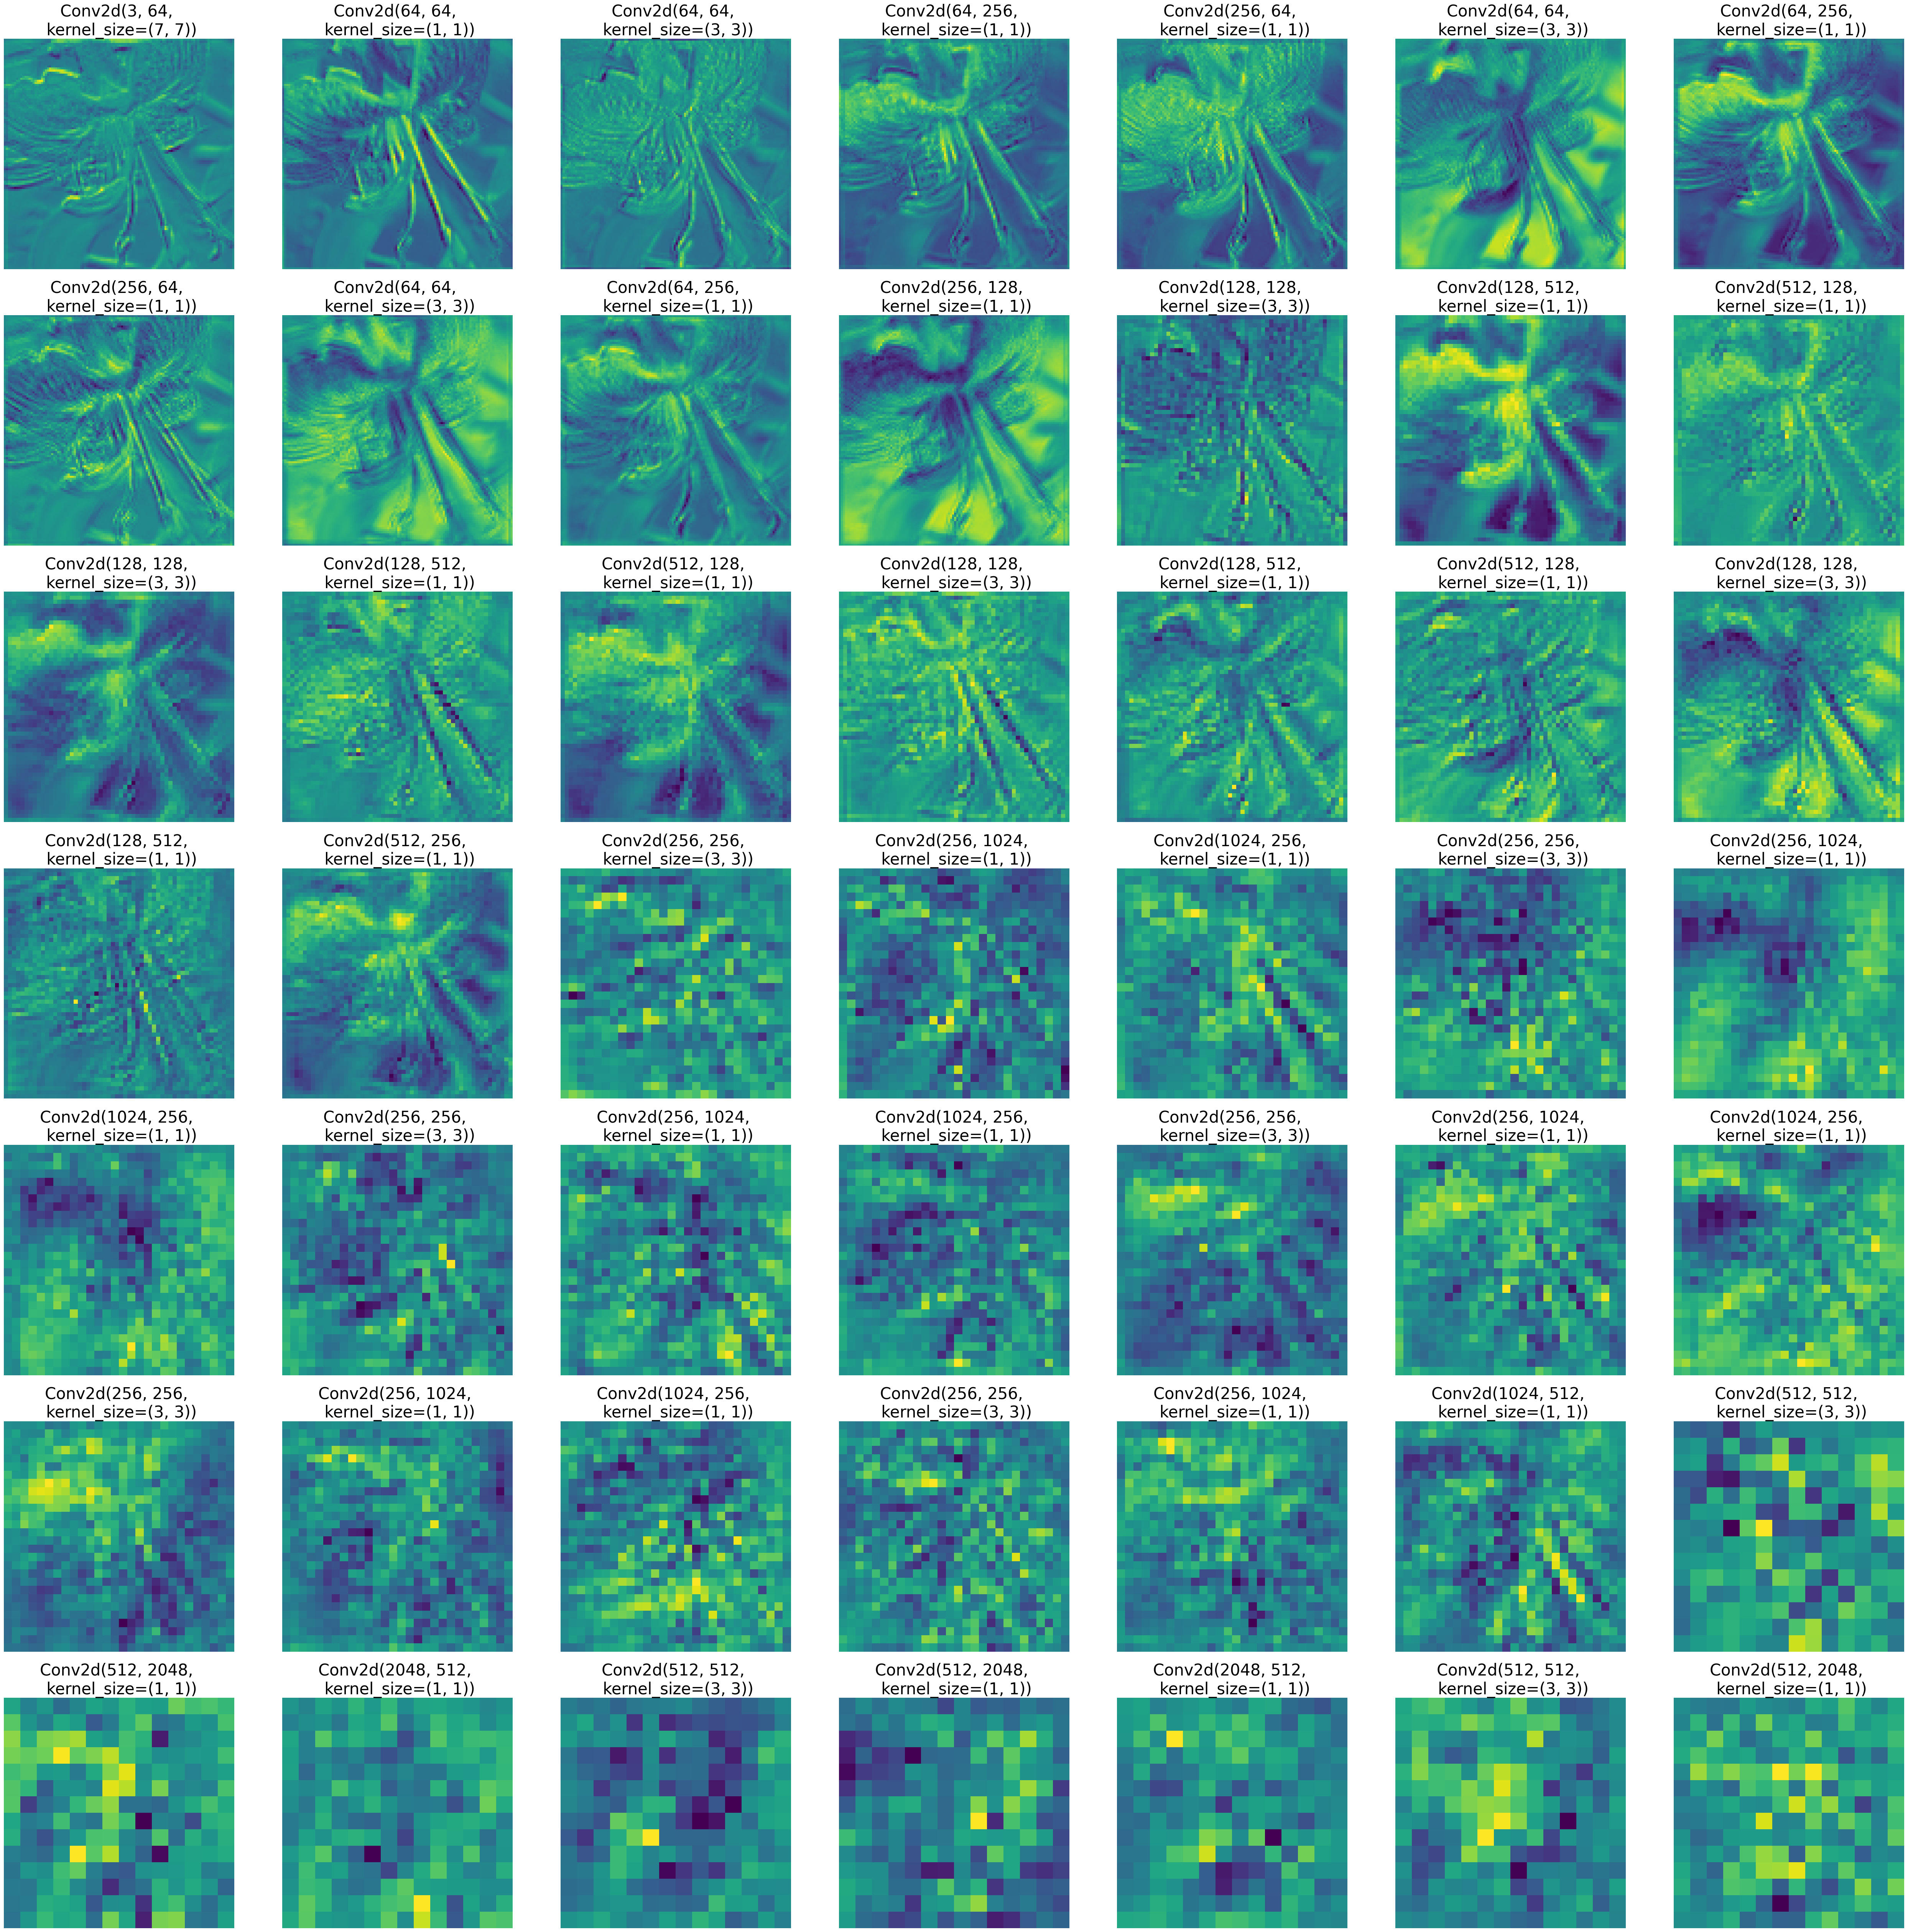

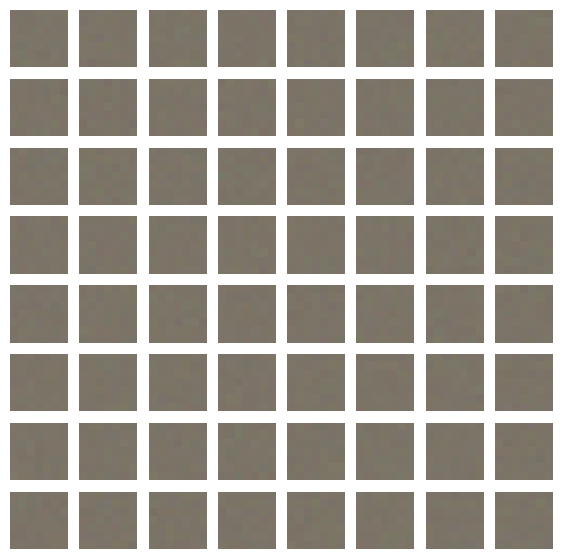

Epoch [1/2000] Training Loss: 0.8183


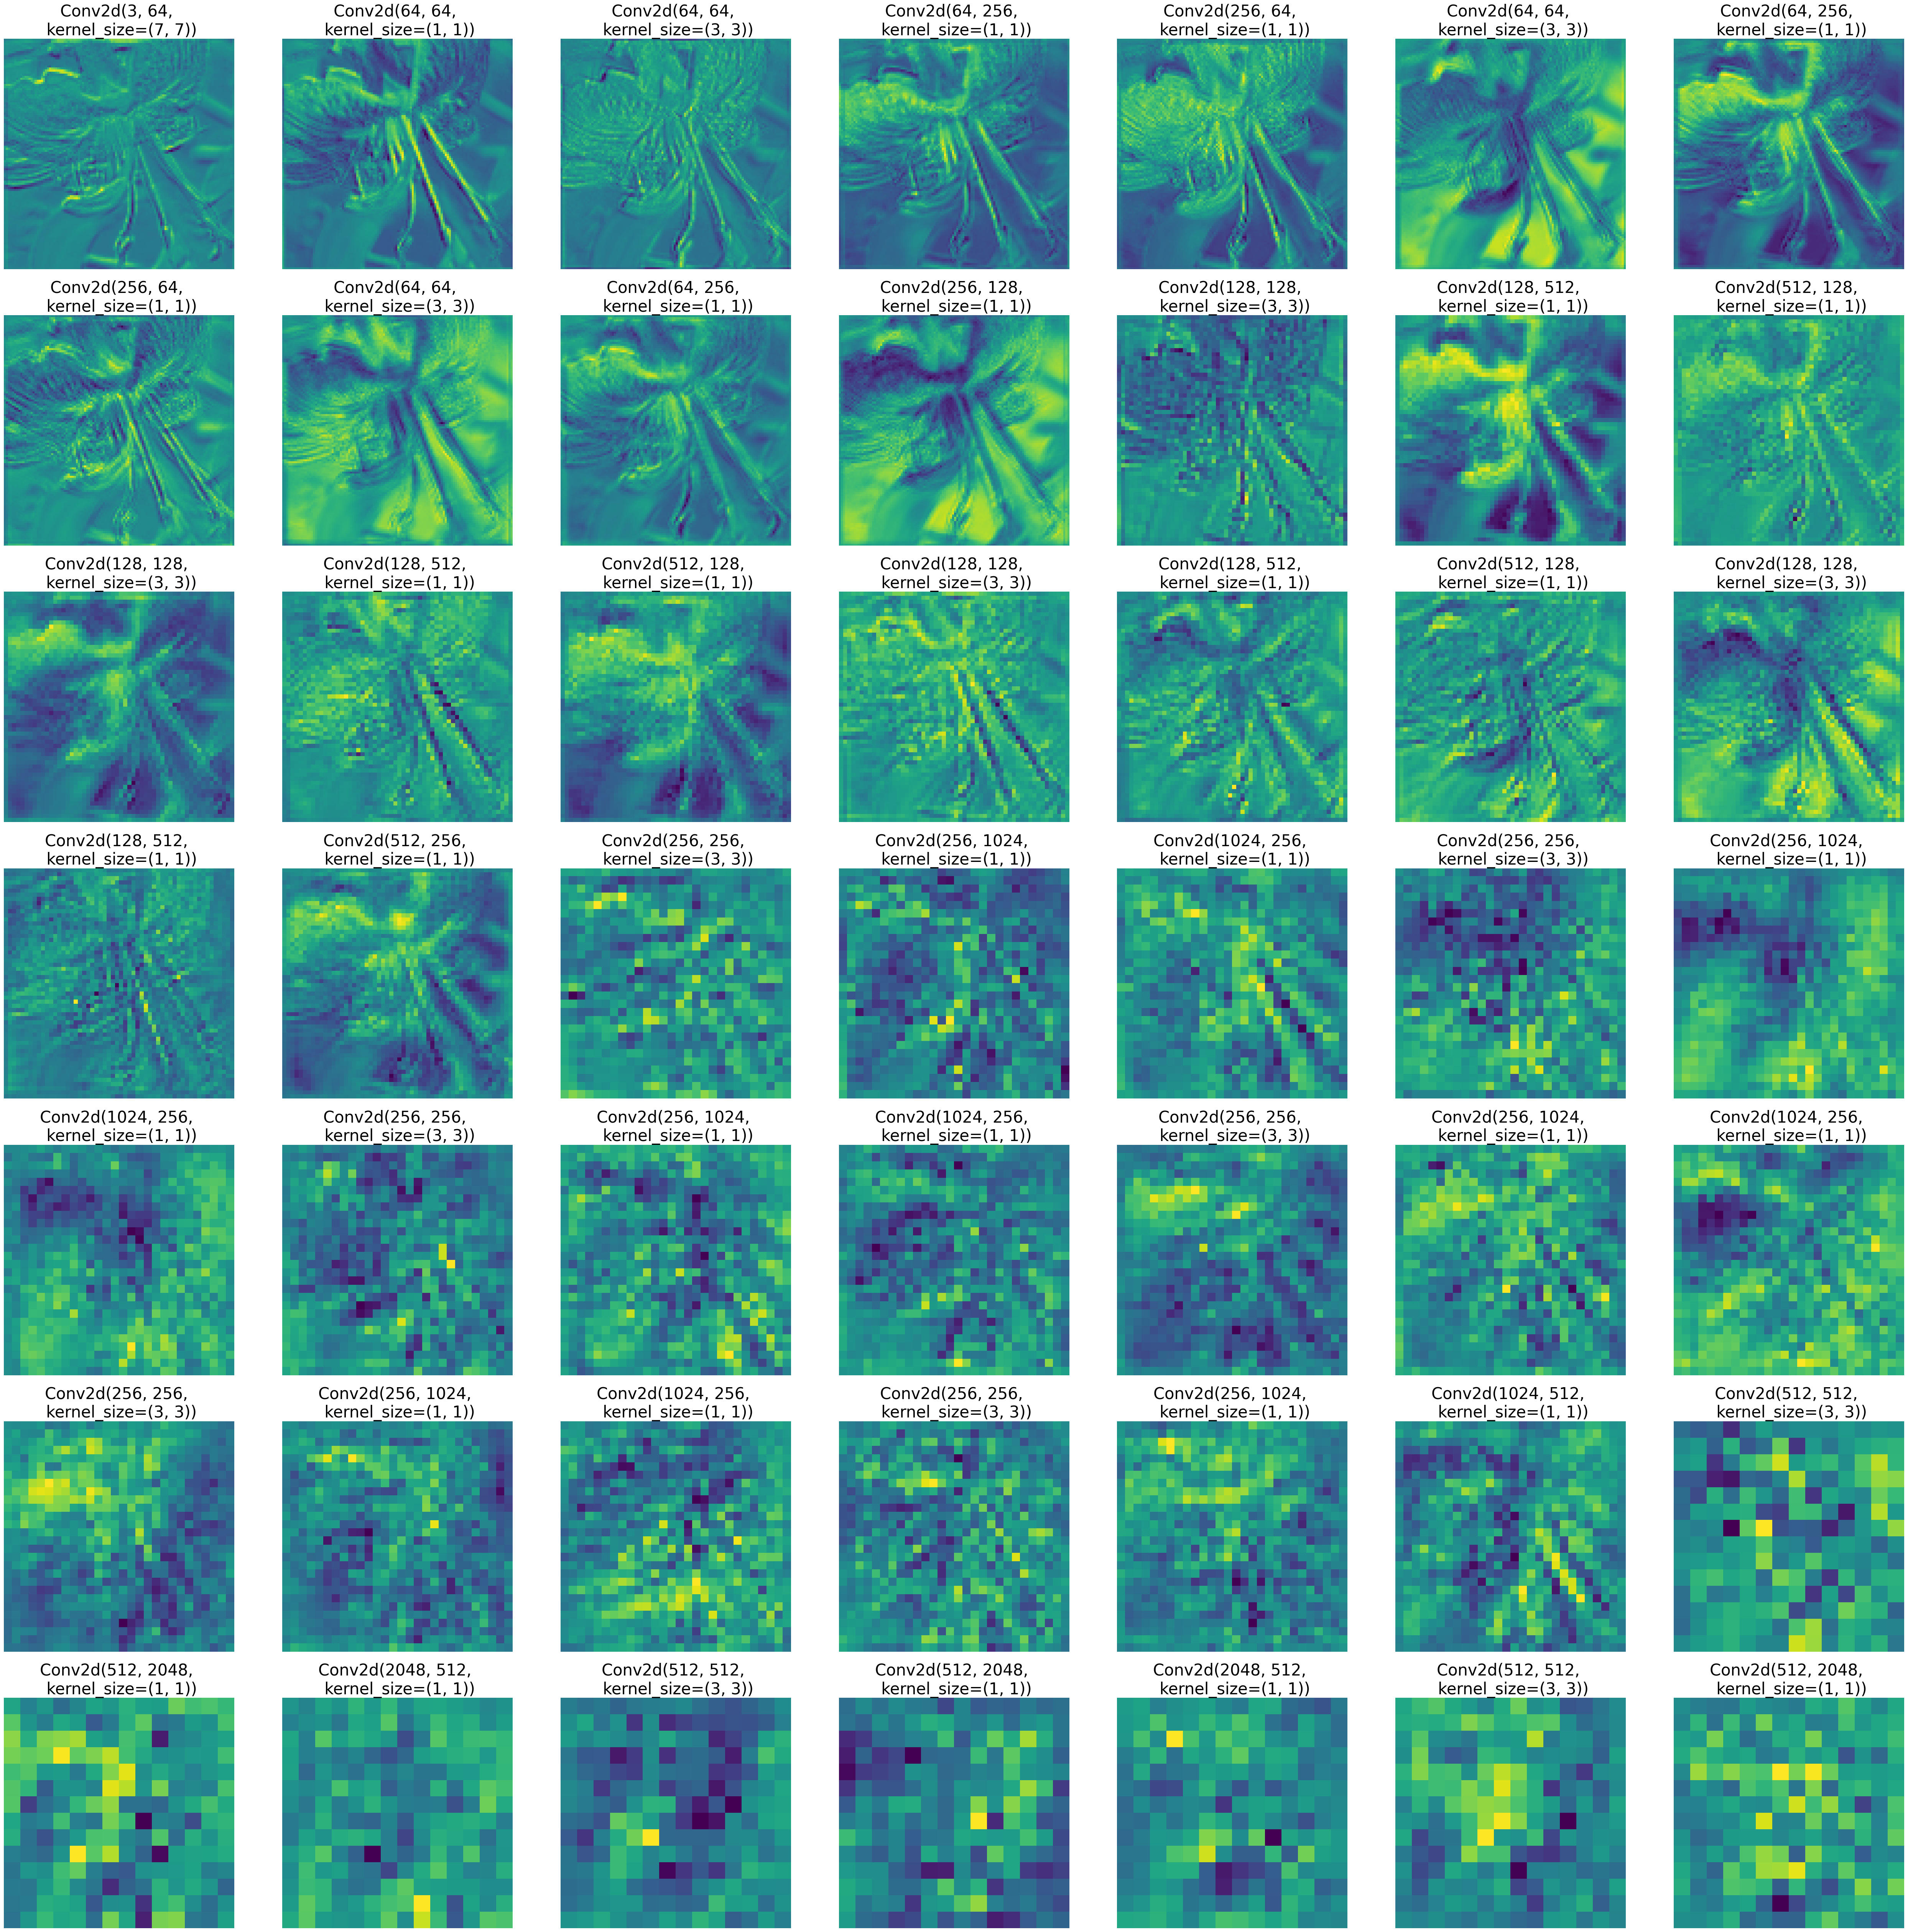

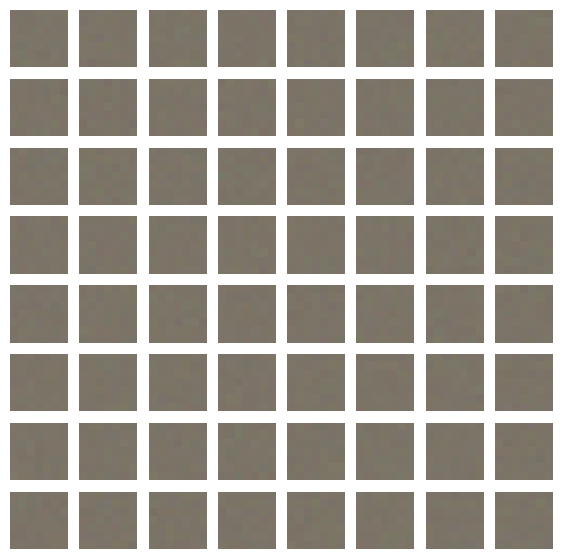

Epoch [2000/2000] Training Loss: 0.6367
Training complete


In [11]:
# Training loop
num_epochs = 2000
model.train()  # Set the model to training mode
inputs, classes = next(iter(dataloaders['val']))
inputs = inputs.to(device)
test_image = inputs[0]

for epoch in range(num_epochs):
  if epoch == 0 or epoch == 1999:
    conv_layers, model_weights = layer_listing(model)
    visualize(conv_layers, model_weights, test_image)
    for batch in dataloaders['train']:
        inputs, targets = batch
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()  # Compute gradients
        optimizer.step()  # Update model parameters
    print(f'Epoch [{epoch + 1}/{num_epochs}] Training Loss: {loss.item():.4f}')

print('Training complete')

### PreTrained ResNet50
Now, we can look at the pretrained ResNet50, to see how the filters change.

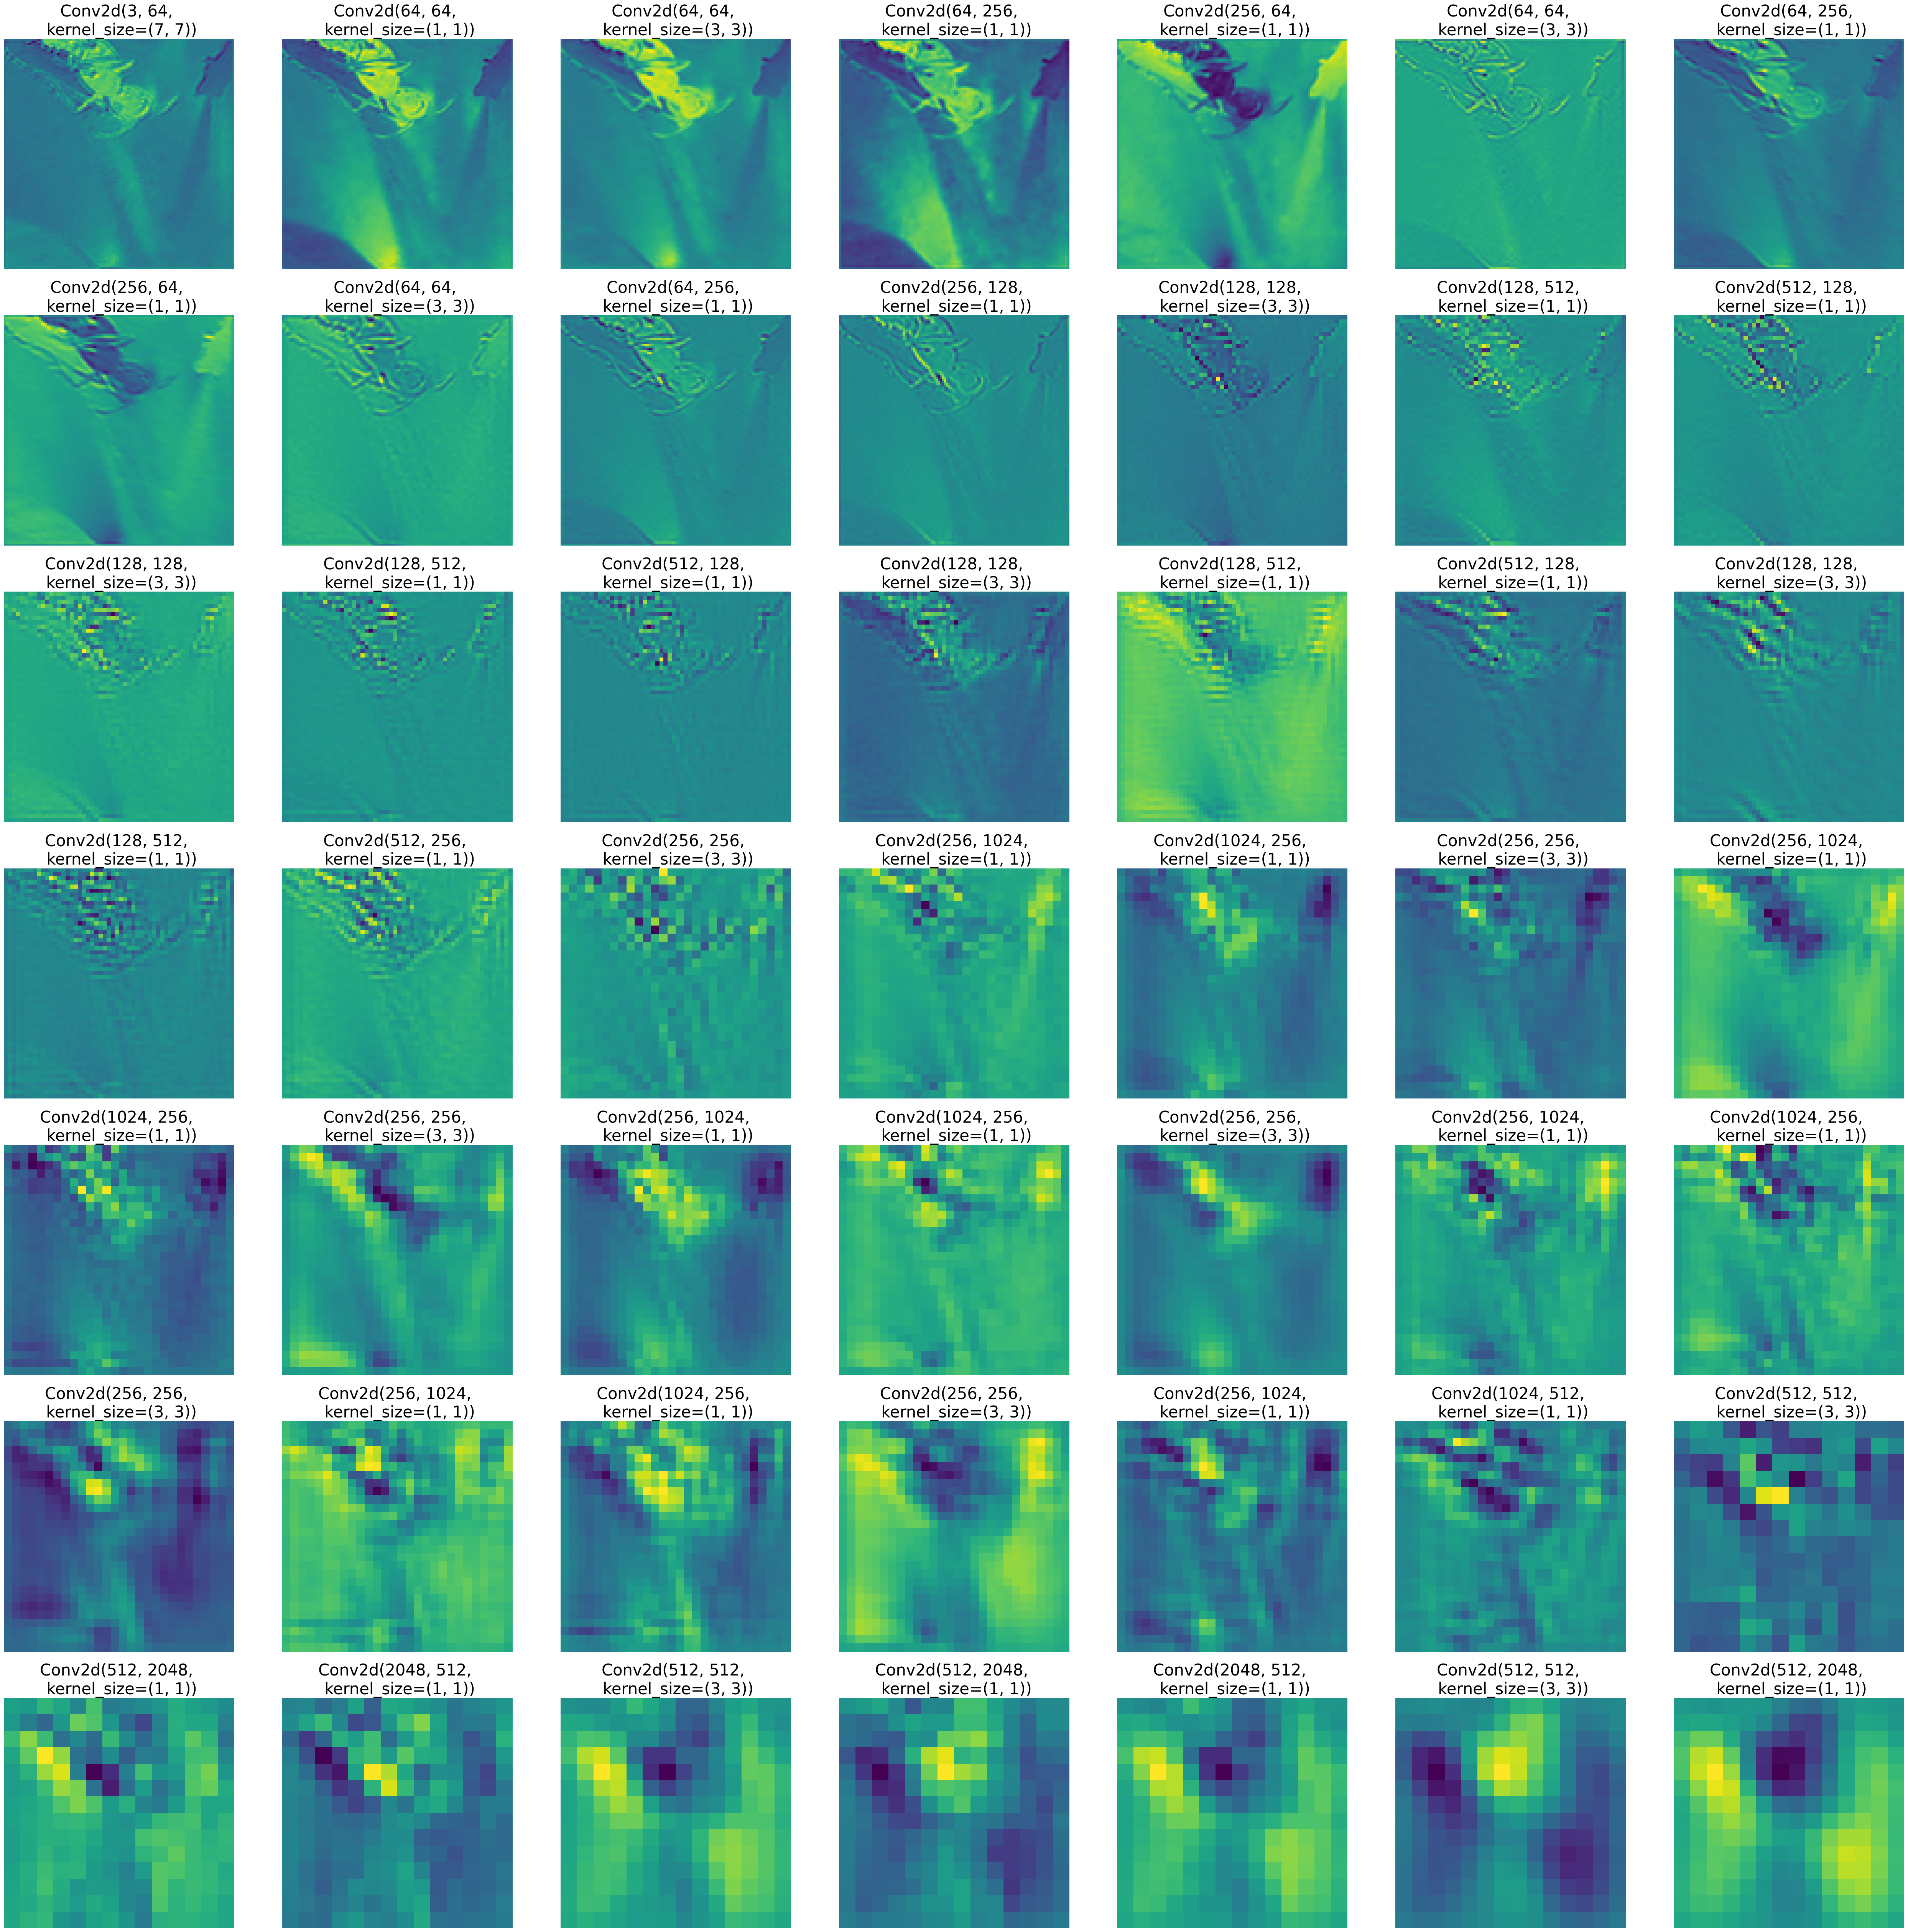

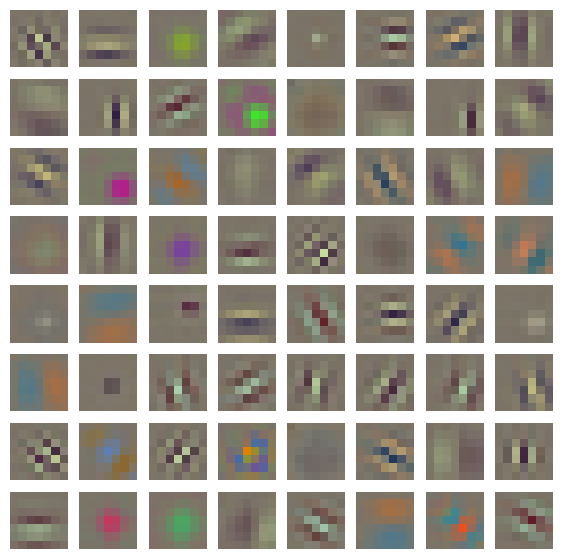

Epoch [1/25] Training Loss: 0.2985


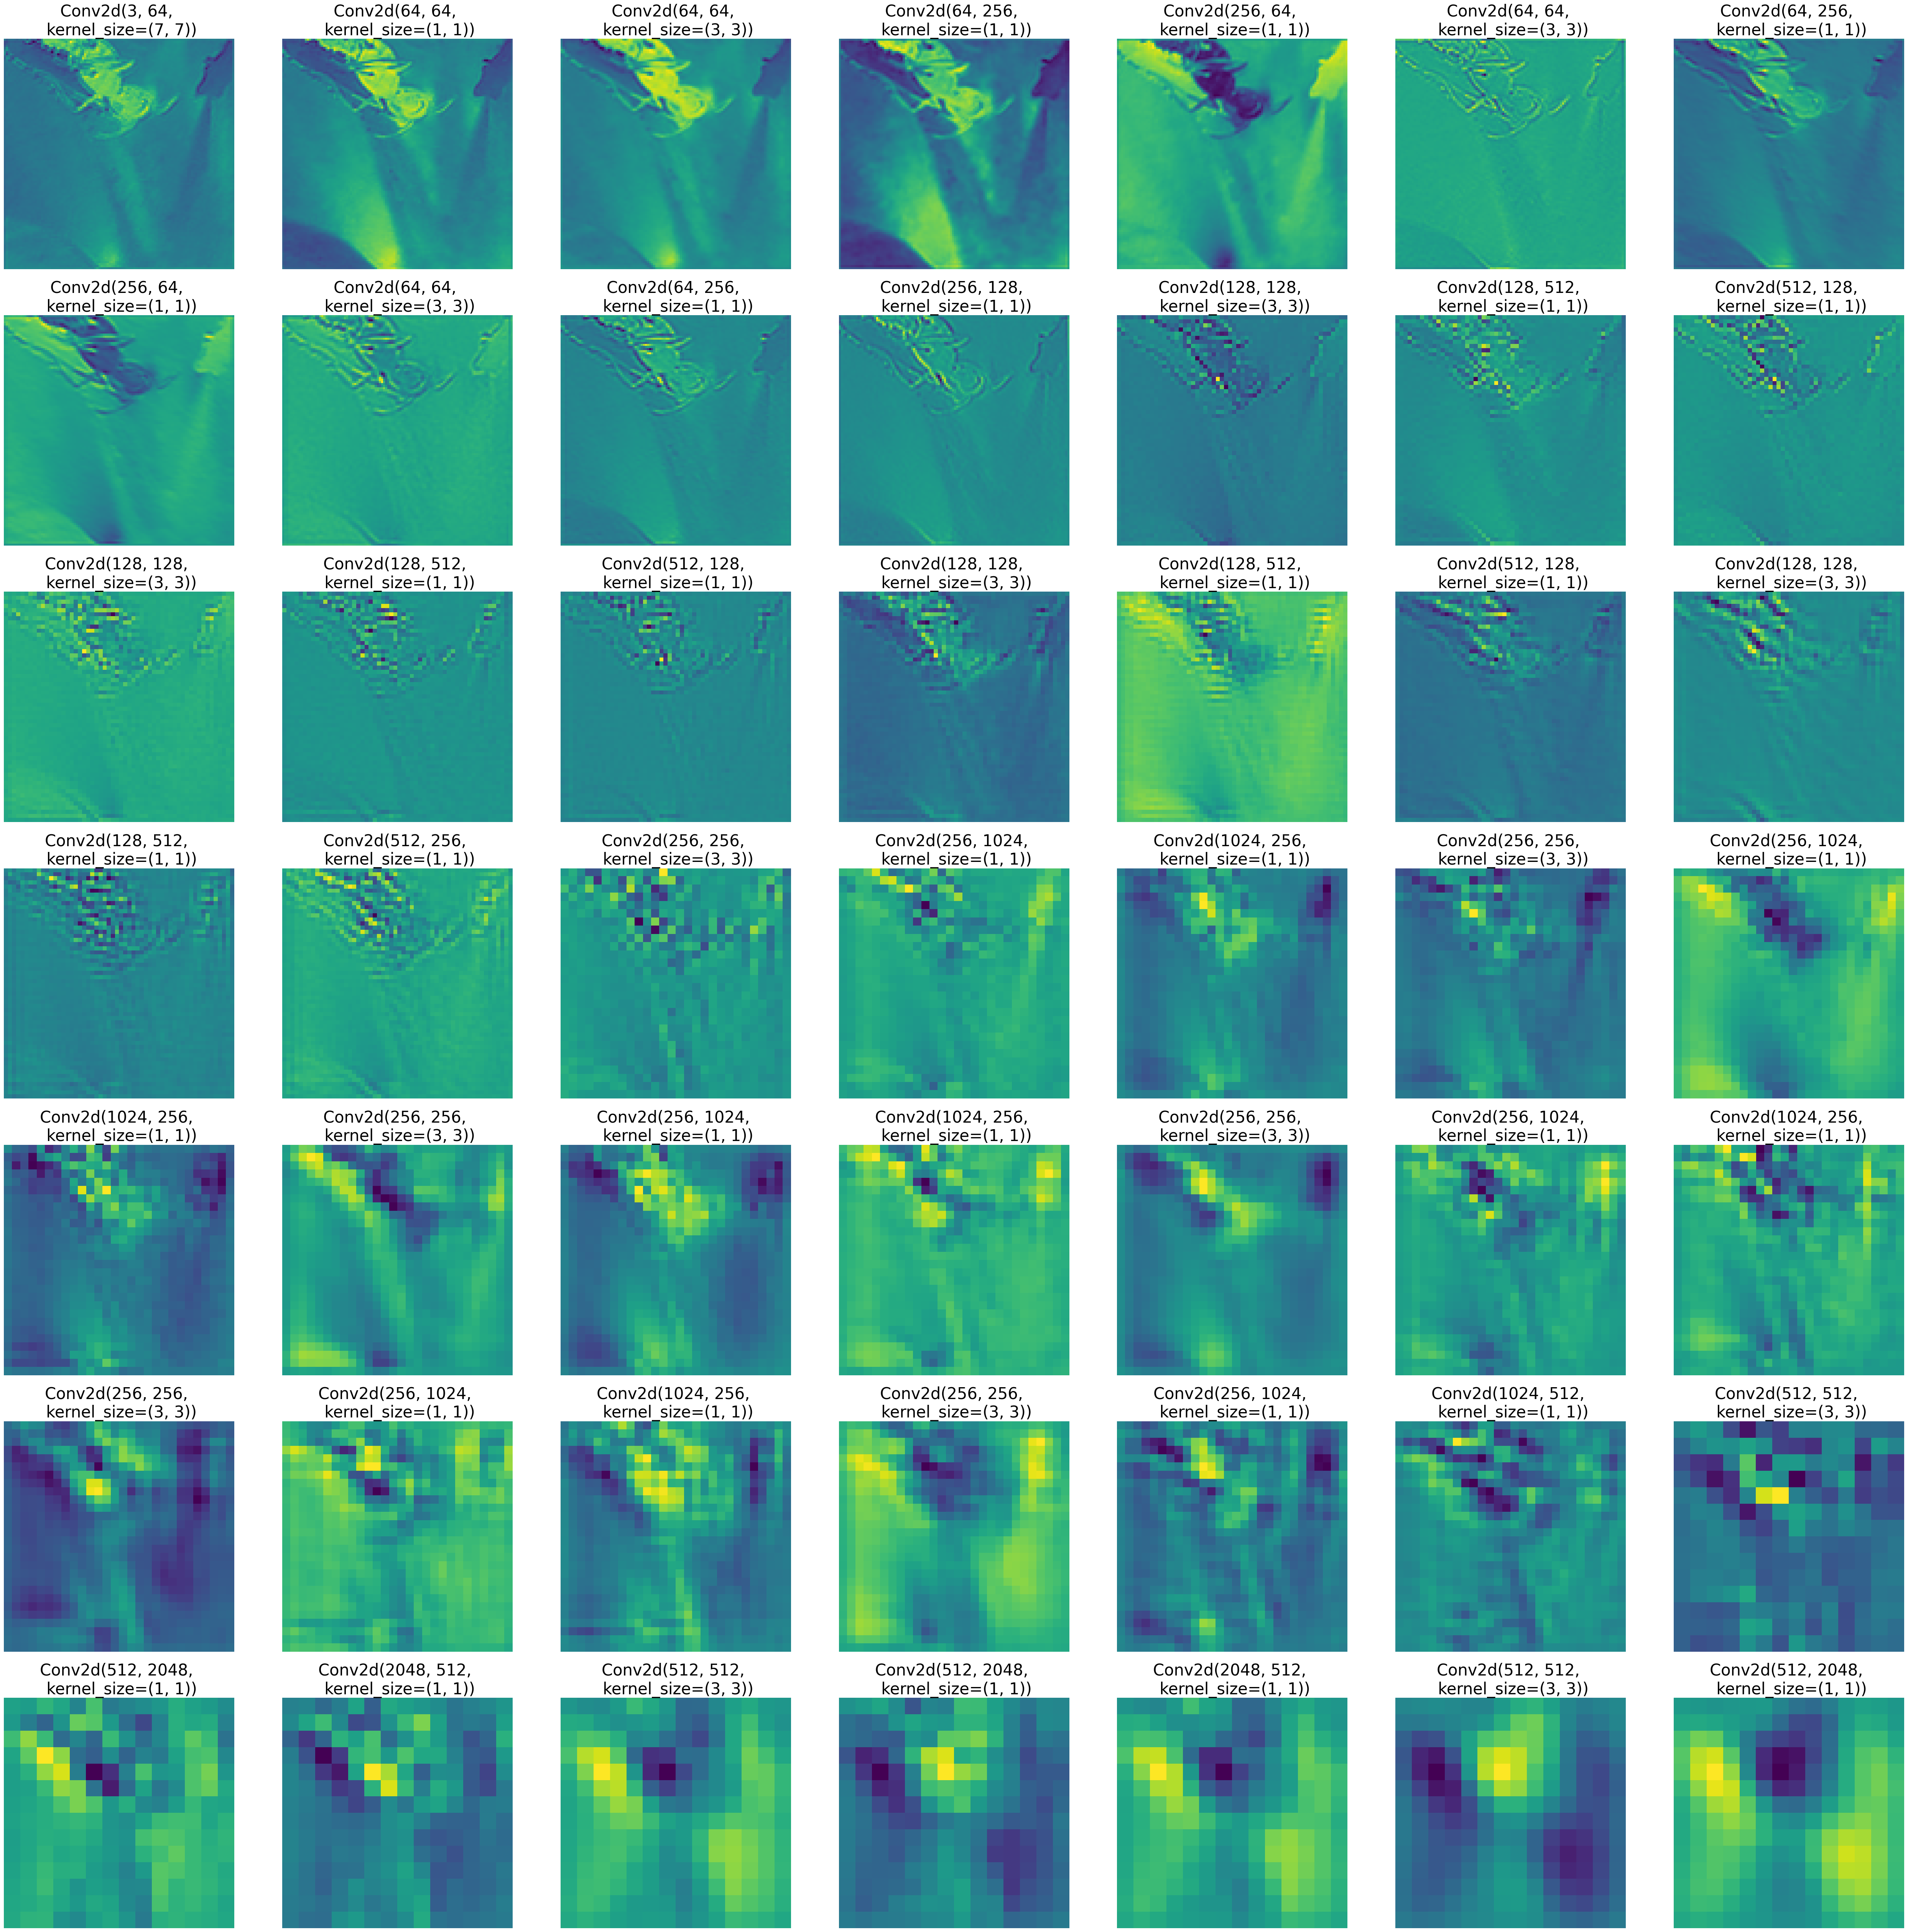

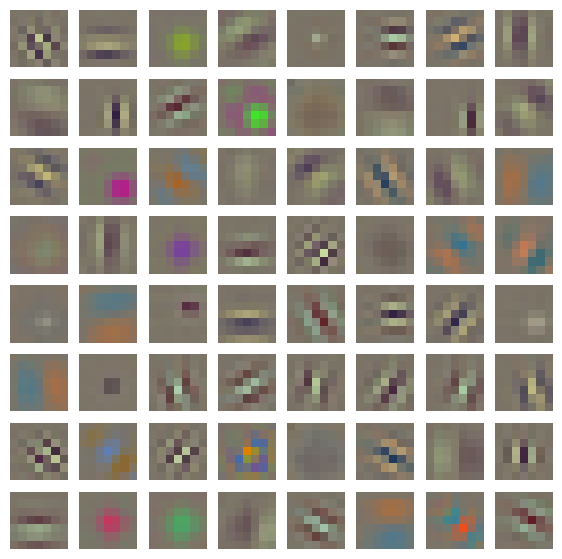

Epoch [25/25] Training Loss: 0.3524
Training complete


In [12]:
# Training loop
num_epochs = 25
pretrained_model.train()  # Set the model to training mode
test_image = inputs[0]

for epoch in range(num_epochs):
  if epoch == 0 or epoch == 24:
    conv_layers, model_weights = layer_listing(pretrained_model)
    visualize(conv_layers, model_weights, test_image)
    for batch in dataloaders['train']:
        inputs, targets = batch
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()  # Zero the gradients
        outputs = pretrained_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()  # Compute gradients
        optimizer.step()  # Update model parameters
    print(f'Epoch [{epoch + 1}/{num_epochs}] Training Loss: {loss.item():.4f}')

print('Training complete')

In [13]:
pretrained_model.eval()  # Set the model to evaluation mode

total_loss = 0
total_samples = 0
correct_predictions = 0

with torch.no_grad():
    for batch in dataloaders['val']:
        inputs, targets = batch
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = pretrained_model(inputs)
        loss = criterion(outputs, targets)  # Use the same criterion as in training
        total_loss += loss.item() * inputs.size(0)
        total_samples += inputs.size(0)

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == targets).sum().item()

average_loss = total_loss / total_samples
print(f'Test Loss: {average_loss:.4f}')
testing_accuracy = correct_predictions / total_samples
print(f'Test Accuracy: {testing_accuracy:.4f}')

Test Loss: 0.2564
Test Accuracy: 0.9216
